# Transporter statistics and taxonomic profiles

## Overview

In this notebook some overview statistics of the datasets are computed and taxonomic profiles investigated. The notebook uses data produced by running the [01.process_data](01.process_data.ipynb) notebook.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt, matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [29]:
def make_tax_table(df,name="",rank="superkingdom"):
    df_t = df.groupby(rank).sum()
    df_tp = df_t.div(df_t.sum())*100
    df_tp_mean = df_tp.mean(axis=1)
    df_tp_max = df_tp.max(axis=1)
    df_tp_min = df_tp.min(axis=1)
    df_tp_sd = df_tp.std(axis=1)
    table = pd.concat([df_tp_mean,df_tp_max,df_tp_min,df_tp_sd],axis=1)
    table.columns = [name+" mean(%)",name+" max(%)",name+" min(%)",name+" std"]
    table.rename(index=lambda x: x.split("_")[0], inplace=True)
    return table

## Load the data

In [30]:
transinfo = pd.read_csv("selected_transporters_classified.tab", header=0, sep="\t", index_col=0)
transinfo.head()

,substrate_category,type,name,abbreviation
transporter,,,,
T1068,AA peptide + (NH4+),2a,cyclic peptide transporter,AA-PEP
T534,AA peptide + (NH4+),2a,lao: LAO/AO transport,AA-PEP
T52,AA peptide + (NH4+),2a,livcs: branched-chain amino acid transport,AA-PEP
T37,AA peptide + (NH4+),2a,potA: polyamine ABC transporter,AA-PEP
T42,AA peptide + (NH4+),3a,proV: glycine betaine/L-proline,AA-PEP


Read gene abundance values with taxonomic annotations.

In [31]:
mg_cov = pd.read_table("data/mg/all_genes.tpm.taxonomy.tsv.gz", header=0, sep="\t", index_col=0)
mt_cov = pd.read_table("data/mt/all_genes.tpm.taxonomy.tsv.gz", header=0, sep="\t", index_col=0)

Read orf level transporter data.

In [32]:
mg_transcov = pd.read_table("results/mg/all_transporters.tpm.taxonomy.tsv.gz", header=0, sep="\t", index_col=0)
mt_transcov = pd.read_table("results/mt/all_transporters.tpm.taxonomy.tsv.gz", header=0, sep="\t", index_col=0)

In [33]:
mg_select_transcov = pd.read_table("results/mg/select_trans_genes.tpm.tsv", header=0, sep="\t", index_col=0)
mt_select_transcov = pd.read_table("results/mt/select_trans_genes.tpm.tsv", header=0, sep="\t", index_col=0)

Read transporter abundances.

In [34]:
mg_trans = pd.read_csv("results/mg/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mt_trans = pd.read_csv("results/mt/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)

## Generate taxonomic overview table

In [35]:
mg_tax_table = make_tax_table(mg_cov,name="MG ")
mg_tax_table_cyano = make_tax_table(mg_cov,name="MG ",rank="phylum").loc["Cyanobacteria"]
mg_tax_table = pd.concat([mg_tax_table,pd.DataFrame(mg_tax_table_cyano).T])
mg_tax_table

,MG mean(%),MG max(%),MG min(%),MG std
Archaea,0.444465,2.950890,0.085917,0.529389
Bacteria,75.428436,85.955231,56.856845,7.647321
Eukaryota,17.714500,39.503928,7.105921,7.992095
Unclassified,0.000000,0.000000,0.000000,0.000000
Unclassified.sequences,0.069640,0.128687,0.028277,0.025251
Viruses,6.342546,16.513082,1.153748,3.157483
other sequences,0.000414,0.002230,0.000000,0.000505
Cyanobacteria,2.573587,6.453542,0.933766,1.347171


In [36]:
mt_tax_table = make_tax_table(mt_cov,name="MT ")
mt_tax_table_cyano = make_tax_table(mt_cov,name="MT ",rank="phylum").loc["Cyanobacteria"]
mt_tax_table = pd.concat([mt_tax_table,pd.DataFrame(mt_tax_table_cyano).T])
mt_tax_table

,MT mean(%),MT max(%),MT min(%),MT std
Archaea,0.187601,1.688748,0.007643,0.336348
Bacteria,54.304835,91.842676,4.862725,19.191191
Eukaryota,44.096314,95.067494,7.198724,19.814593
Unclassified,0.000000,0.000000,0.000000,0.000000
Unclassified.sequences,0.023082,0.062690,0.000794,0.014553
Viruses,1.388080,12.631377,0.044287,2.546334
other sequences,0.000089,0.000460,0.000000,0.000142
Cyanobacteria,4.830159,27.397589,0.337568,5.569118


Concatenate overview tables. This is **Table 2** in the paper.

In [37]:
tax_table = pd.concat([mg_tax_table,mt_tax_table],axis=1).round(2)

In [38]:
tax_table.to_csv("results/Table2.tsv",sep="\t")

## Generate general overview of transporters

Make table with number of ORFs, ORFs classified as transporters, min, mean and max coverage for transporter ORFs.

In [39]:
num_genes = len(mg_cov)
gene_lengths = pd.read_table("data/mg/all_genes.tpm.tsv.gz", usecols=[1])
gene_lengths = np.round(gene_lengths.mean())

In [40]:
def generate_transporter_stats(df):
    # Number of transporter genes (genes with sum > 0)
    num_trans_genes = len(df.loc[df.groupby(level=0).sum().sum(axis=1)>0])
    # Percent of transporter genes
    num_trans_genes_p = np.round((num_trans_genes / float(num_genes))*100,2)
    # Mean total coverage for transporter genes across the samples
    transcov_mean = np.round(((df.groupby(level=0).sum().sum().mean()) / 1e6)*100,2)
    # Minimum total coverage for transporter genes across the samples
    transcov_min = np.round(((df.groupby(level=0).sum().sum().min()) / 1e6)*100,2)
    # Maximum ...
    transcov_max = np.round(((df.groupby(level=0).sum().sum().max()) / 1e6)*100,2)
    # Standard dev
    transcov_std = np.round(((df.groupby(level=0).sum().sum() / 1e6)*100).std(),2)
    return num_trans_genes, num_trans_genes_p, transcov_mean, transcov_min, transcov_max, transcov_std

In [41]:
mg_num_trans_genes, mg_num_trans_genes_p, mg_transcov_mean, mg_transcov_min, mg_transcov_max, mg_transcov_std = generate_transporter_stats(mg_transcov)

In [42]:
mt_num_trans_genes, mt_num_trans_genes_p, mt_transcov_mean, mt_transcov_min, mt_transcov_max, mt_transcov_std = generate_transporter_stats(mt_transcov)

Create table with transporter statistics for MG and MT datasets (**Table 3** in the paper).

In [43]:
stats_df = pd.DataFrame(data={
                   "Transporter genes": ["{} ({}%)".format(mg_num_trans_genes,mg_num_trans_genes_p),"{} ({}%)".format(mt_num_trans_genes,mt_num_trans_genes_p)],
                   "Transporter mean": ["{}%".format(mg_transcov_mean),"{}%".format(mt_transcov_mean)],
                   "Transporter min": ["{}%".format(mg_transcov_min),"{}%".format(mt_transcov_min)],
                   "Transporter max": ["{}%".format(mg_transcov_max),"{}%".format(mt_transcov_max)],
                   "Transporter std": ["{}%".format(mg_transcov_std),"{}%".format(mt_transcov_std)]},index=["MG","MT"]).T
stats_df.to_csv("results/Table3.tsv",sep="\t")
stats_df

,MG,MT
Transporter genes,39634 (0.85%),20166 (0.43%)
Transporter max,1.23%,1.28%
Transporter mean,0.94%,0.78%
Transporter min,0.55%,0.07%
Transporter std,0.2%,0.29%


Do the same with the selected transporters.

In [44]:
mg_select_num_trans_genes, mg_select_num_trans_genes_p, mg_select_transcov_mean, mg_select_transcov_min, mg_select_transcov_max, mg_select_transcov_std = generate_transporter_stats(mg_select_transcov)

In [45]:
mt_select_num_trans_genes, mt_select_num_trans_genes_p, mt_select_transcov_mean, mt_select_transcov_min, mt_select_transcov_max, mt_select_transcov_std = generate_transporter_stats(mt_select_transcov)

In [46]:
select_stats_df = pd.DataFrame(data={
                   "Selected transporter genes": ["{} ({}%)".format(mg_select_num_trans_genes,mg_select_num_trans_genes_p),"{} ({}%)".format(mt_select_num_trans_genes,mt_select_num_trans_genes_p)],
                   "Selected transporter mean": ["{}%".format(mg_select_transcov_mean),"{}%".format(mt_select_transcov_mean)],
                   "Selected transporter min": ["{}%".format(mg_select_transcov_min),"{}%".format(mt_select_transcov_min)],
                   "Selected transporter max": ["{}%".format(mg_select_transcov_max),"{}%".format(mt_select_transcov_max)],
                   "Selected transporter std": ["{}%".format(mg_select_transcov_std),"{}%".format(mt_select_transcov_std)]},index=["mg_select","mt_select"]).T
select_stats_df.to_csv("results/selected_transporter_stats.tab",sep="\t")
select_stats_df

,mg_select,mt_select
Selected transporter genes,17289 (0.37%),8552 (0.18%)
Selected transporter max,0.59%,0.56%
Selected transporter mean,0.42%,0.31%
Selected transporter min,0.23%,0.04%
Selected transporter std,0.09%,0.12%


## Generate kingdom/phylum level taxonomic plots

In [47]:
def get_euk_taxa(taxa, df, rank):
    euk_taxa = []
    for t in taxa:
        k = df.loc[df[rank]==t, "superkingdom"].unique()[0]
        if k=="Eukaryota":
            euk_taxa.append(t)
    return euk_taxa

In [48]:
def set_euk_hatches(ax):
    for patch in ax.patches:
        t = color2taxmap[patch.properties()['facecolor'][0:-1]]
        if t in euk_taxa:
            patch.set_hatch("////")

Generate profiles for metagenomes.

In [49]:
# Get sum of abundances at superkingdom level
mg_k = mg_cov.groupby("superkingdom").sum()
# Normalize to %
mg_kn = mg_k.div(mg_k.sum())*100
mg_kn = mg_kn.loc[["Archaea","Bacteria","Eukaryota","Viruses","Unclassified.sequences","other sequences"]]
mg_kn = mg_kn.loc[mg_kn.sum(axis=1).sort_values(ascending=False).index]
# Swtich Proteobacterial classes to phylum
mg_cov.loc[mg_cov.phylum=="Proteobacteria","phylum"] = mg_cov.loc[mg_cov.phylum=="Proteobacteria","class"]
# Normalize at phylum level
mg_p = mg_cov.groupby("phylum").sum()
mg_pn = mg_p.div(mg_p.sum())*100

In [50]:
_ = mg_pn.mean(axis=1).sort_values(ascending=False)
_.loc[~_.index.str.contains("Unclassified")].head(8)

phylum
Bacteroidetes          16.318369
Actinobacteria          8.253850
Alphaproteobacteria     8.240375
Chlorophyta             8.177615
Gammaproteobacteria     7.251923
Verrucomicrobia         3.692036
Betaproteobacteria      3.612124
Cyanobacteria           2.573587
dtype: float64

Create the taxonomic overview of the 7 most abundant phyla in the metagenomic dataset. This is **Figure 1** in the paper.

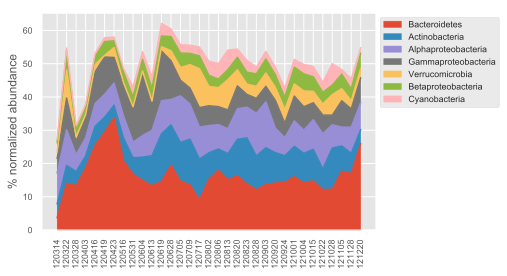

In [51]:
select_taxa = ["Verrucomicrobia","Actinobacteria","Alphaproteobacteria","Gammaproteobacteria","Cyanobacteria","Bacteroidetes","Betaproteobacteria"]
# Sort taxa by mean abundance
taxa_order = mg_pn.loc[select_taxa].mean(axis=1).sort_values(ascending=False).index
ax = mg_pn.loc[taxa_order].T.plot(kind="area",stacked=True)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("% normalized abundance");
xticks = list(range(0,33))
ax.set_xticks(xticks);
ax.set_xticklabels(mg_pn.columns, rotation=90);
plt.savefig("NEW_figures_2020/Figure_1.eps", bbox_inches="tight")

Generate profiles for metatranscriptomes.

In [52]:
# Get sum of abundances at superkingdom level
mt_k = mt_cov.groupby("superkingdom").sum()
# Normalize to %
mt_kn = mt_k.div(mt_k.sum())*100
mt_kn = mt_kn.loc[["Archaea","Bacteria","Eukaryota","Viruses","Unclassified.sequences","other sequences"]]
mt_kn = mt_kn.loc[mt_kn.sum(axis=1).sort_values(ascending=False).index]
# Swtich Proteobacterial classes to phylum
mt_cov.loc[mt_cov.phylum=="Proteobacteria","phylum"] = mt_cov.loc[mt_cov.phylum=="Proteobacteria","class"]
# Normalize at phylum level
mt_p = mt_cov.groupby("phylum").sum()
mt_pn = mt_p.div(mt_p.sum())*100

Get common taxa for both datasets by taking the union of the top 15 most abundant taxa

In [53]:
mg_taxa = mg_pn.mean(axis=1).sort_values(ascending=False).head(15).index
mt_taxa = mt_pn.mean(axis=1).sort_values(ascending=False).head(15).index
taxa = set(mg_taxa).union(set(mt_taxa))

Single out eukaryotic taxa

In [54]:
euk_taxa = get_euk_taxa(taxa, mg_cov, rank="phylum")

Sort the taxa by their mean abundance in the mg data

In [55]:
taxa_sort = mg_pn.loc[taxa].mean(axis=1).sort_values(ascending=False).index
taxa_colors = dict(zip(taxa_sort,(sns.color_palette("Set1",7)+sns.color_palette("Set2",7)+sns.color_palette("Dark2",5))))
color2taxmap = {}
for t, c in taxa_colors.items():
    color2taxmap[c] = t

Plot metagenome profiles

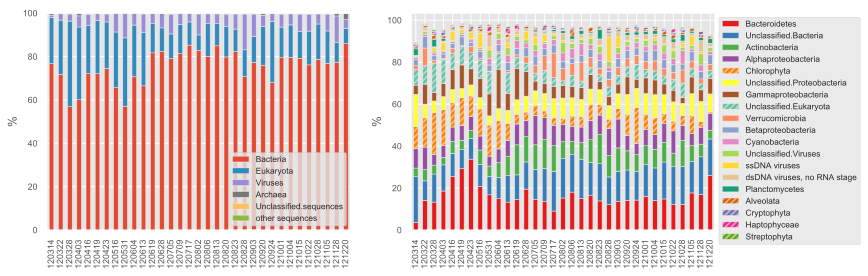

In [56]:
fig,axes = plt.subplots(ncols=2,nrows=1, figsize=(12,4))
# Plot the kingdoms
ax1 = mg_kn.T.plot(kind="bar",stacked=True,ax=axes[0])
ax1.legend(loc="lower right",fontsize="small")
ax1.set_ylabel("%")

# Plot the phyla
ax2 = mg_pn.loc[taxa_sort].T.plot(kind="bar",stacked=True, color=[taxa_colors[tax] for tax in taxa_sort], legend=None,ax=axes[1])
set_euk_hatches(ax2)
ax2.set_ylabel("%")
ax2.legend(bbox_to_anchor=(1,1),fontsize="small");

Plot metatranscriptome profiles

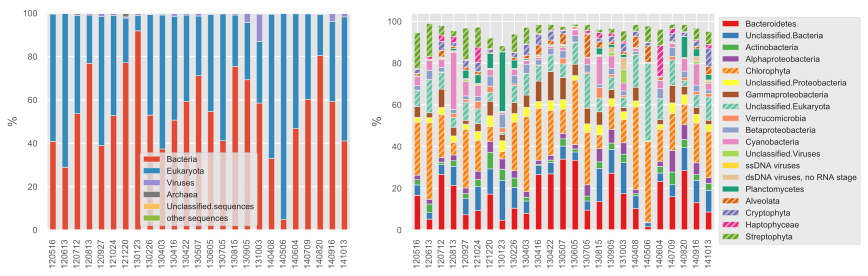

In [57]:
fig,axes = plt.subplots(ncols=2,nrows=1, figsize=(12,4))
# Plot the kingdoms
ax1 = mt_kn.T.plot(kind="bar",stacked=True,ax=axes[0])
ax1.legend(loc="lower center",fontsize="small")
ax1.set_ylabel("%")

# Plot the phyla
ax2 = mt_pn.loc[taxa_sort].T.plot(kind="bar",stacked=True, color=[taxa_colors[tax] for tax in taxa_sort], legend=None,ax=axes[1])
set_euk_hatches(ax2)
ax2.set_ylabel("%")
ax2.legend(bbox_to_anchor=(1,1),fontsize="small");

Calculate total number of orders.

In [58]:
mg_ordersum = mg_cov.groupby("order").sum()
mg_total_orders = len(mg_ordersum.loc[mg_ordersum.sum(axis=1)>0])
print("{} orders in the entire mg dataset".format(mg_total_orders))

mg_trans_ordersum = mg_select_transcov.groupby("order").sum()
mg_trans_total_orders = len(mg_trans_ordersum.loc[mg_trans_ordersum.sum(axis=1)>0])
print("{} orders in the transporter mg dataset".format(mg_trans_total_orders))

1262 orders in the entire mg dataset
193 orders in the transporter mg dataset


In [59]:
mt_ordersum = mt_cov.groupby("order").sum()
mt_total_orders = len(mt_ordersum.loc[mt_ordersum.sum(axis=1)>0])
print("{} orders in the entire mt dataset".format(mt_total_orders))

mt_trans_ordersum = mt_select_transcov.groupby("order").sum()
mt_trans_total_orders = len(mt_trans_ordersum.loc[mt_trans_ordersum.sum(axis=1)>0])
print("{} orders in the transporter mt dataset".format(mt_trans_total_orders))

823 orders in the entire mt dataset
133 orders in the transporter mt dataset


## Calculate and plot distributions per taxonomic subsets.

Extract ORFs belonging to each subset.

In [60]:
cya_orfs = mg_transcov.loc[mg_transcov.phylum=="Cyanobacteria"].index
bac_orfs = mg_transcov.loc[(mg_transcov.phylum!="Cyanobacteria")&(mg_transcov.superkingdom=="Bacteria")].index
euk_orfs = mg_transcov.loc[mg_transcov.superkingdom=="Eukaryota"].index

Calculate contribution of taxonomic subsets to the identified transporters.

In [61]:
taxgroup_df = pd.DataFrame(columns=["MG","MT"],index=["Bacteria","Cyanobacteria","Eukaryota"])

In [62]:
mg_all_transcov_info = pd.merge(transinfo,mg_transcov,left_index=True,right_on="transporter")
mg_bac_transcov_info = pd.merge(transinfo,mg_transcov.loc[bac_orfs],left_index=True,right_on="transporter")
mg_euk_transcov_info = pd.merge(transinfo,mg_transcov.loc[euk_orfs],left_index=True,right_on="transporter")
mg_cya_transcov_info = pd.merge(transinfo,mg_transcov.loc[cya_orfs],left_index=True,right_on="transporter")

In [63]:
mt_all_transcov_info = pd.merge(transinfo,mt_transcov,left_index=True,right_on="transporter")
mt_bac_transcov_info = pd.merge(transinfo,mt_transcov.loc[bac_orfs],left_index=True,right_on="transporter")
mt_euk_transcov_info = pd.merge(transinfo,mt_transcov.loc[euk_orfs],left_index=True,right_on="transporter")
mt_cya_transcov_info = pd.merge(transinfo,mt_transcov.loc[cya_orfs],left_index=True,right_on="transporter")

In [64]:
mg_cya_part = mg_cya_transcov_info.groupby("transporter").sum().sum().div(mg_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mg_cya_part.min(),mg_cya_part.max(),mg_cya_part.mean()
taxgroup_df.loc["Cyanobacteria","MG"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

mg_euk_part = mg_euk_transcov_info.groupby("transporter").sum().sum().div(mg_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mg_euk_part.min(),mg_euk_part.max(),mg_euk_part.mean()
taxgroup_df.loc["Eukaryota","MG"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

mg_bac_part = mg_bac_transcov_info.groupby("transporter").sum().sum().div(mg_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mg_bac_part.min(),mg_bac_part.max(),mg_bac_part.mean()
taxgroup_df.loc["Bacteria","MG"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

In [65]:
mt_cya_part = mt_cya_transcov_info.groupby("transporter").sum().sum().div(mt_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mt_cya_part.min(),mt_cya_part.max(),mt_cya_part.mean()
taxgroup_df.loc["Cyanobacteria","MT"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

mt_euk_part = mt_euk_transcov_info.groupby("transporter").sum().sum().div(mt_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mt_euk_part.min(),mt_euk_part.max(),mt_euk_part.mean()
taxgroup_df.loc["Eukaryota","MT"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

mt_bac_part = mt_bac_transcov_info.groupby("transporter").sum().sum().div(mt_all_transcov_info.groupby("transporter").sum().sum())*100
mi,ma,me = mt_bac_part.min(),mt_bac_part.max(),mt_bac_part.mean()
taxgroup_df.loc["Bacteria","MT"] = "{}% ({}-{}%)".format(round(me,2),round(mi,2),round(ma,2))

In [66]:
taxgroup_df

,MG,MT
Bacteria,94.86% (89.28-97.19%),77.68% (20.53-97.09%)
Cyanobacteria,2.09% (0.45-8.06%),5.84% (0.26-36.5%)
Eukaryota,2.82% (0.42-8.03%),16.45% (2.36-78.67%)


### Taxonomic subsets per substrate category

In [67]:
def calculate_mean_total_substrate_subset(df,df_sum,subset,var_name="Sample",value_name="%"):
    cols = ["fam","transporter","substrate_category","name"]
    # Sum to protein family
    x = df.groupby(["fam","transporter","substrate_category","name"]).sum().reset_index()
    cols.pop(cols.index("fam"))
    # Calculate mean of transporters
    x.groupby(cols).mean().reset_index()
    xt = x.copy()
    # Normalize to sum of all transporters
    x.iloc[:,4:] = x.iloc[:,4:].div(df_sum)*100
    # Sum percent to substrate category
    x = x.groupby("substrate_category").sum()
    # Melt dataframe and add subset column
    x["substrate_category"] = x.index
    xm = pd.melt(x,id_vars="substrate_category", var_name="Sample",value_name="%")
    xm = xm.assign(Subset=pd.Series(data=subset,index=xm.index))
    return xm,xt

In [68]:
# Get contribution of bacterial transporters to total for substrate category
mg_bac_cat_melt,mg_bac_cat = calculate_mean_total_substrate_subset(mg_bac_transcov_info,mg_trans.sum(),"Bacteria")
# Get contribution of eukaryotic transporters to total for substrate category
mg_euk_cat_melt,mg_euk_cat = calculate_mean_total_substrate_subset(mg_euk_transcov_info,mg_trans.sum(),"Eukaryota")
# Get contribution of cyanobacterial transporters to total for substrate category
mg_cya_cat_melt,mg_cya_cat = calculate_mean_total_substrate_subset(mg_cya_transcov_info,mg_trans.sum(),"Cyanobacteria")

In [69]:
# Get contribution of bacterial transporters to total for substrate category
mt_bac_cat_melt,mt_bac_cat = calculate_mean_total_substrate_subset(mt_bac_transcov_info,mt_trans.sum(),"Bacteria")
# Get contribution of eukaryotic transporters to total for substrate category
mt_euk_cat_melt,mt_euk_cat = calculate_mean_total_substrate_subset(mt_euk_transcov_info,mt_trans.sum(),"Eukaryota")
# Get contribution of cyanobacterial transporters to total for substrate category
mt_cya_cat_melt,mt_cya_cat = calculate_mean_total_substrate_subset(mt_cya_transcov_info,mt_trans.sum(),"Cyanobacteria")

In [70]:
# Concatenate dataframes for metagenomes
mg_subsets_cat = pd.concat([pd.concat([mg_bac_cat_melt,mg_euk_cat_melt]),mg_cya_cat_melt])
mg_subsets_cat = mg_subsets_cat.assign(dataset=pd.Series(data="MG",index=mg_subsets_cat.index))

In [71]:
# Concatenate dataframes for metagenomes
mt_subsets_cat = pd.concat([pd.concat([mt_bac_cat_melt,mt_euk_cat_melt]),mt_cya_cat_melt])
mt_subsets_cat = mt_subsets_cat.assign(dataset=pd.Series(data="MT",index=mt_subsets_cat.index))

**Concatenate MG and MT**

In [72]:
subsets_cat = pd.concat([mg_subsets_cat,mt_subsets_cat])

### Plot substrate category distributions

In [73]:
cats = transinfo.substrate_category.unique()

In [75]:
# Update Eukaryota subset label
subsets_cat.loc[subsets_cat.Subset=="Eukaryota","Subset"] = ["Picoeukaryota"]*len(subsets_cat.loc[subsets_cat.Subset=="Eukaryota","Subset"])

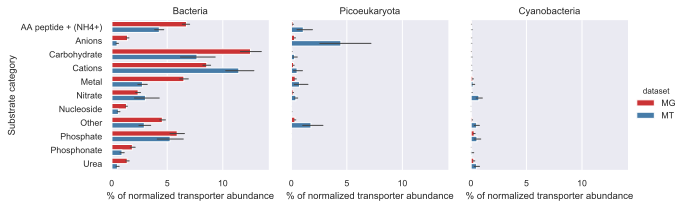

In [77]:
sns.set(font_scale=0.8)
ax = sns.catplot(kind="bar",data=subsets_cat.loc[subsets_cat.substrate_category.isin(cats)],hue="dataset", 
                 y="substrate_category", x="%", col="Subset",
                    errwidth=1, height=3, palette="Set1", aspect=1)
ax.set_titles("{col_name}")
ax.set_axis_labels("% of normalized transporter abundance","Substrate category")

plt.savefig("NEW_figures_2020/Figure_2.eps", bbox_inches="tight")

In [54]:
_ = mg_transcov.groupby(["fam","transporter"]).sum().reset_index()
_ = _.groupby("transporter").mean()
_ = pd.merge(transinfo, _, left_index=True, right_index=True)
_ = _.loc[_.substrate_category=="Carbohydrate"].groupby("name").sum()
(_.div(_.sum())*100).mean(axis=1).sort_values(ascending=False).head(3).sum()

71.542935622537584